In [12]:
import os, glob
import shutil
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.io.votable import parse_single_table

import pickle

from tqdm import tqdm_notebook as tqdm

In [2]:
def make_velocity_axis(h):
    """ Creates the velocity axis given a header. Assumes the third
        axis is the velocity axis in km/s using the radio definition.
        """

    array = (np.arange(h['NAXIS3']) - h['CRPIX3'] + 1) * h['CDELT3'] + h['CRVAL3']

    return array / 1000.

# Read in absorption table

In [3]:
abs_file = './askap_spectra.vot'
table = parse_single_table(abs_file).array

In [4]:
print('number of absorption spectra: ', len(table['id']))

number of absorption spectra:  373


# Read in old batch of spectra 

Pull coordinates, velocities, tau spectra from spectra received in Summer 2020 just to compare velocity structures of emission and absorption)

In [5]:
spec_dir = './sb10941_10944/spectra/'
spec_files = glob.glob(spec_dir+'*_spec.vot')
print(len(spec_files))

vall = []
tauall = []
ravals = []
decvals = []

count = 0
for spec_file in spec_files:
    stable = parse_single_table(spec_file).array
    vel = stable['velocity']
    optd = stable['opacity']
    rms = stable['sigma_opacity'][0]
    
    coord_name = spec_file.split('spectra/')[1]
    coord_name = coord_name.split('_spec.vot')[0]
    ras = coord_name.split('-')[0]
    ras = ras[1:3]+'h '+ras[3:5]+'m '+ras[5:7]+'s'
    decs = coord_name.split('-')[1]
    decs = '-'+decs[0:2]+'d '+decs[2:4]+'m '+decs[4:6]+'s'
    
    coord_str = ras + ' ' + decs
    
    c = SkyCoord(coord_str, frame='icrs')
    ra = c.fk5.ra.degree
    dec = c.fk5.dec.degree
    
    ravals.append(ra)
    decvals.append(dec)
    
    vall = vall + [vel]
    tauall = tauall + [optd]

vall = np.array(vall)
tauall = np.array(tauall)

373


# Read in latest ASKAP cube

In [6]:
askap_file = 'SMC_askap_parkes_PBC_pilot_K_SM.fits'
askap_cube, askap_header = fits.getdata(askap_file, header=True)
askap_cube = np.squeeze(askap_cube)

# Compute velocity axis
askap_vel = make_velocity_axis(askap_header) 

# Define WCS 
wcs_askap = WCS(askap_header)

# Strip third axis in new header for N(HI) plot below
askap_h2 = askap_header.copy()
del askap_h2['NAXIS3'] 
askap_h2['NAXIS'] = 2
del askap_h2['CDELT3']
del askap_h2['CRPIX3']
del askap_h2['CRVAL3']
del askap_h2['CTYPE3']
askap_h2['WCSAXES'] = 2
w2 = WCS(askap_h2)

Compute pixel coordinates of absorption positions

In [7]:
pixcoord = wcs_askap.wcs_world2pix(table['ra'],table['dec'],0, 0)

Plot column density map and locations of absorption targets

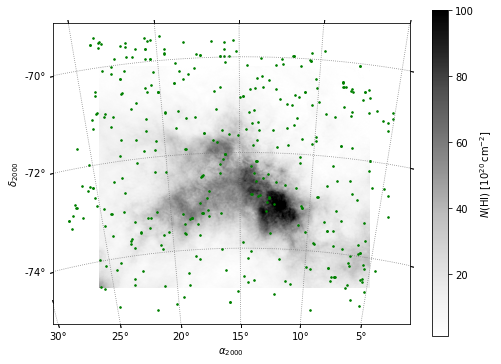

In [8]:
fig = plt.figure(0,[8,6])
ax = fig.add_subplot(111, projection=w2)

ccmap = 'Greys'

dv_askap = np.abs(askap_vel[1]-askap_vel[0])

im = ax.imshow(np.nansum(askap_cube, axis=0)*dv_askap*0.01823, cmap=ccmap, vmin=1, vmax=100, origin='lower')
ax.scatter(pixcoord[0], pixcoord[1], marker='.', s=10, color='green', zorder=1)

ax.set_xlabel(r'$\alpha_{2000}$')
ax.set_ylabel(r'$\delta_{2000}$')

raax = ax.coords['ra']
decax = ax.coords['dec']
raax.set_major_formatter('dd')
decax.set_major_formatter('dd') 
ax.grid(color='grey', ls='dotted', zorder=1)

plt.colorbar(im, label=r'$N({\rm HI})\,\,[\rm 10^{20}\,cm^{-2}]$')

Extract all Tb(v) spectra in annuli surrounding each absorption target, plot and compare with (closest available) tau spectrum

/Users/clairemurray/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


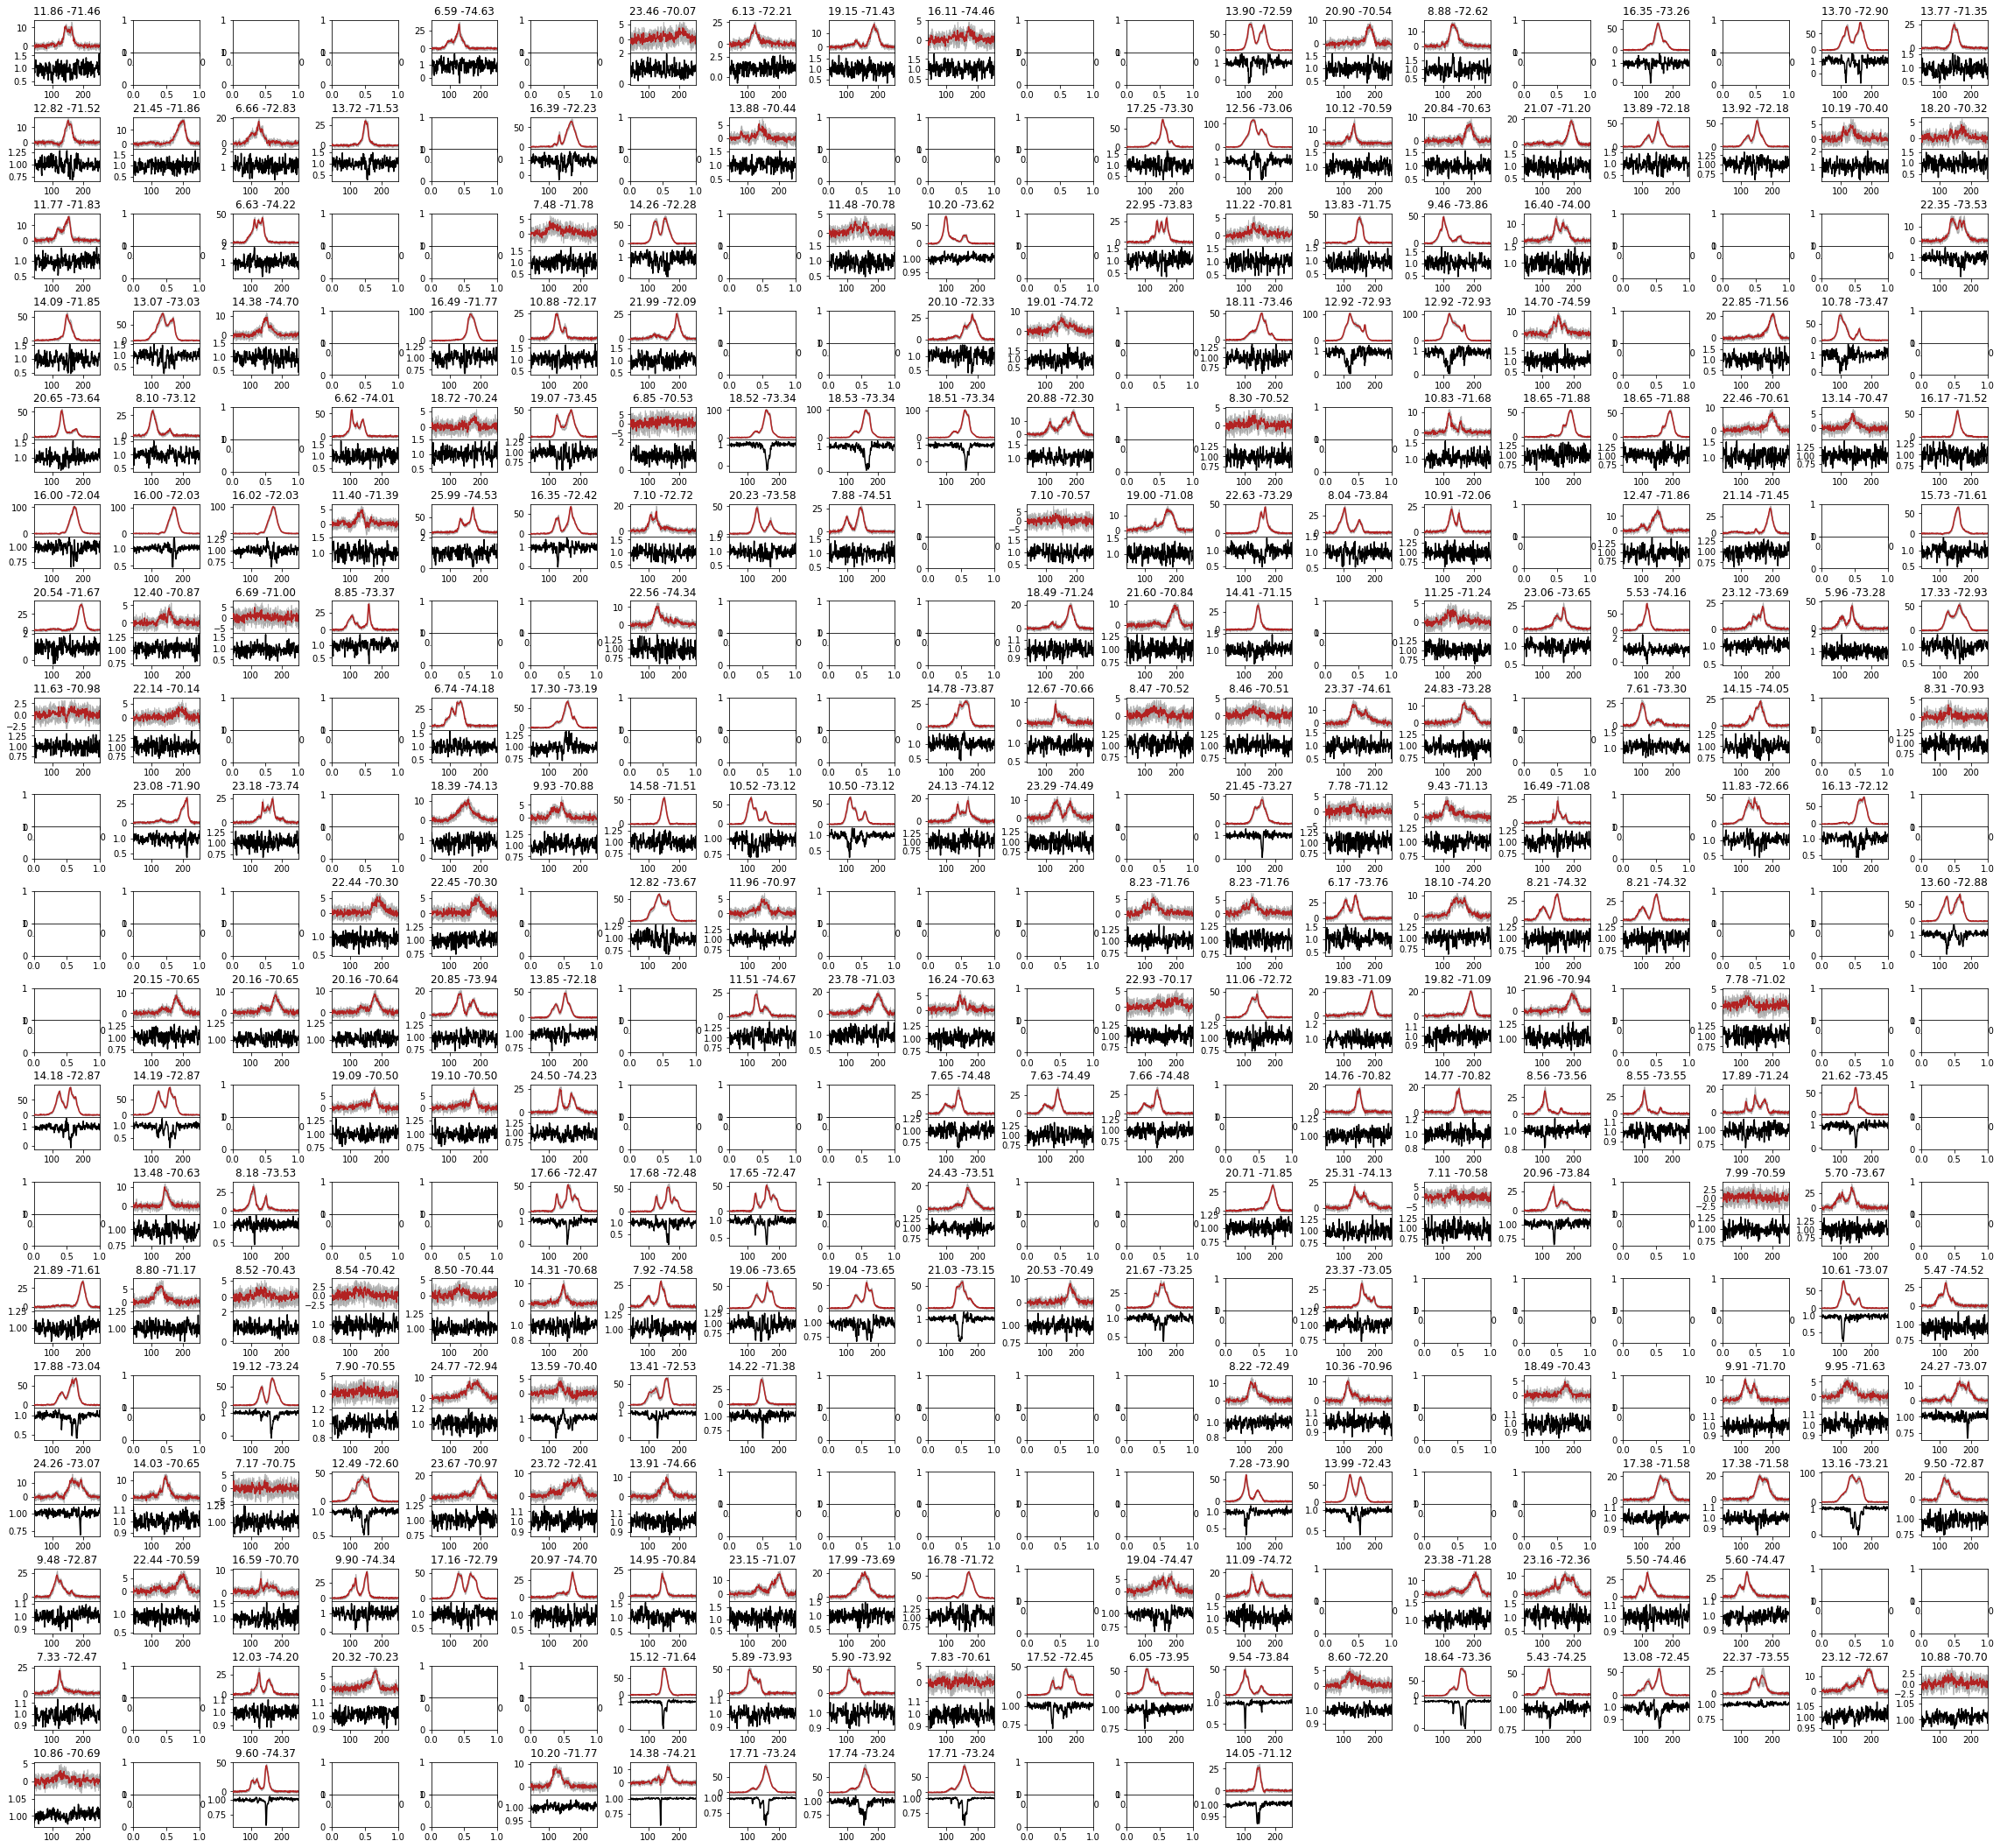

In [22]:
fig = plt.figure(figsize=(40,40), constrained_layout=False)
outer_grid = fig.add_gridspec(20,20, wspace=0.5, hspace=0.5)

# Define outer (R2) and inner (R1) radii of the extraction annulus
R2 = 8
R1 = 4

tball = []
tberr = []
for i in tqdm(range(len(table['id']))):
    inner_grid = outer_grid[i].subgridspec(2, 1, wspace=0., hspace=0.)

    ax_em = fig.add_subplot(inner_grid[0])
    ax_abs = fig.add_subplot(inner_grid[1])

    xp = np.int(pixcoord[1][i])
    yp = np.int(pixcoord[0][i])
    
    # Only pull spectra whose positions fall on the footprint of the cube (this should be all, right?)
    if (xp > R2) and (xp < np.shape(askap_cube)[1]-R2) and (yp > R2) and (yp < np.shape(askap_cube)[2]-R2):

        # Define pixel coordinates of a grid surrounding each target
        center = (xp, yp)
        imin = center[0] - R2
        imax = center[0] + R2 + 1
        jmin = center[1] - R2
        jmax = center[1] + R2 + 1

        # loop through and pile in all spectra which fall in the annulus, based on their distance
        # from the central pixel
        sub_specx = []
        for k in np.arange(imin, imax):
            for j in np.arange(jmin, jmax):
                kj = np.array([k, j])
                dist = np.linalg.norm(kj - np.array(center))
                if dist > R1 and dist <= R2:
                    spec = askap_cube[:, kj[0], kj[1]]
                    sub_specx = sub_specx + [spec]
#                     ax_em.plot(askap_vel, spec, zorder=1, color='grey', alpha=0.2)
        
        # Compute the mean over all spectra
        tb_mean = np.nanmean(sub_specx, axis=0)
        # Estimate the uncertainty per channel via the standard deviation over all spectra
        tb_std = np.nanstd(sub_specx, axis=0)
        
        ax_em.plot(askap_vel, tb_mean, color='firebrick', zorder=4)
        ax_em.fill_between(askap_vel, tb_mean-tb_std, tb_mean+tb_std, color='grey', alpha=0.5, zorder=1)
        
        tball = tball + [tb_mean]
        tberr = tberr + [tb_std]
        
        # Find the closest available absorption target (from old sample) and plot tau(v) for comparison
        spot = np.argmin(np.abs(ravals-table['ra'][i])).ravel()[0]
        ax_abs.plot(vall[spot]/1e3, tauall[spot], color='black')
        
        ax_em.set_title(str('{0:.2f}'.format(table['ra'][i]))+' '+str('{0:.2f}'.format(table['dec'][i])))
        ax_abs.set_xlim(np.min(askap_vel), np.max(askap_vel))
        ax_em.set_xlim(np.min(askap_vel), np.max(askap_vel))
    else:
        # if the target falls outside the cube footprint, save zeros
        tball = tball + [np.zeros(len(askap_vel))]
        tberr = tberr + [np.zeros(len(askap_vel))]
    
plt.tight_layout()

# Export extracted spectra to file

In [23]:
ll = {}
ll['ids'] = table['id']
ll['ra'] = table['ra']
ll['dec'] = table['dec']
ll['tb_mean'] = tball
ll['tb_err'] = tberr
pickle.dump(ll, open('tb_mean_spec.pickle', 'wb'))